In [9]:
import os
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

# Function to augment a single image
def simple_augment_image(img):
    """Apply random augmentations to an image."""
    # Random horizontal flip
    if random.random() < 0.5:
        img = cv2.flip(img, 1)

    # Random rotation (-15° to 15°)
    angle = random.randint(-15, 15)
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    img = cv2.warpAffine(img, rotation_matrix, (w, h))

    # Add random brightness
    if random.random() < 0.5:
        value = random.randint(-50, 50)
        img = cv2.convertScaleAbs(img, alpha=1, beta=value)

    return img

# Function to augment forged images and increase their count by 50%
def augment_forged_images(forged_path, desired_increase=0.5):
    """Augment forged images to increase their count by the specified percentage."""
    # List all images in the forged folder
    forged_images = [f for f in os.listdir(forged_path) if os.path.isfile(os.path.join(forged_path, f))]
    num_existing = len(forged_images)
    num_to_generate = int(num_existing * desired_increase)  # Calculate 50% increase

    print(f"Existing forged images: {num_existing}")
    print(f"Augmenting to generate additional {num_to_generate} images.")

    for i in range(num_to_generate):
        # Pick a random image from the existing forged images
        random_filename = random.choice(forged_images)
        img_path = os.path.join(forged_path, random_filename)
        img = cv2.imread(img_path)

        if img is not None:
            # Augment the image
            augmented_img = simple_augment_image(img)
            # Save augmented image with a unique name
            augmented_filename = f"{os.path.splitext(random_filename)[0]}_aug_{i}.png"
            cv2.imwrite(os.path.join(forged_path, augmented_filename), augmented_img)

    print(f"Augmented forged images saved in {forged_path}")

# Function to load images and labels from the dataset folders
def load_dataset(dataset_path, augment=False):
    """Load images and labels, optionally augmenting forged images."""
    authentic_path = os.path.join(dataset_path, 'authentic')
    forged_path = os.path.join(dataset_path, 'forged')

    print("Authentic path:", authentic_path)
    print("Forged path:", forged_path)

    # Check if directories exist
    if not os.path.exists(authentic_path):
        raise FileNotFoundError(f"Directory not found: {authentic_path}")
    if not os.path.exists(forged_path):
        raise FileNotFoundError(f"Directory not found: {forged_path}")

    # Apply augmentation to forged images if enabled
    if augment:
        augment_forged_images(forged_path, desired_increase=0.5)

    authentic_images = []
    forged_images = []
    labels = []

    # Load authentic images
    for filename in os.listdir(authentic_path):
        img = cv2.imread(os.path.join(authentic_path, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            authentic_images.append(img)
            labels.append(0)

    # Load forged images
    for filename in os.listdir(forged_path):
        img = cv2.imread(os.path.join(forged_path, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            forged_images.append(img)
            labels.append(1)

    return authentic_images, forged_images, labels

# Path to the dataset
dataset_path = 'DATA/TRAINING'

# Load the dataset with augmentation (50% increase in forged images)
authentic_images, forged_images, labels = load_dataset(dataset_path, augment=True)

# Combine authentic and forged images
X = np.array(authentic_images + forged_images)
y = np.array(labels)

print(f"Dataset loaded successfully. Total images: {len(X)}")


Authentic path: DATA/TRAINING\authentic
Forged path: DATA/TRAINING\forged
Existing forged images: 6182
Augmenting to generate additional 3091 images.
Augmented forged images saved in DATA/TRAINING\forged
Dataset loaded successfully. Total images: 15266


In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

# Function to load images and labels from the dataset folders
def load_dataset(dataset_path):
    authentic_path = os.path.join('DATA/TRAINING', 'authentic')
    tampered_path = os.path.join('DATA/TRAINING', 'forged')

    print("Authentic path:", authentic_path)
    print("Tampered path:", tampered_path)
    # Check if directories exist
    if not os.path.exists(authentic_path):
        raise FileNotFoundError(f"Directory not found: {authentic_path}")
    if not os.path.exists(tampered_path):
        raise FileNotFoundError(f"Directory not found: {tampered_path}")

    # If directories exist, proceed
    authentic_images = []
    tampered_images = []
    labels = []

    for filename in os.listdir(authentic_path):
        img = cv2.imread(os.path.join(authentic_path, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            authentic_images.append(img)
            labels.append(0)

    for filename in os.listdir(tampered_path):
        img = cv2.imread(os.path.join(tampered_path, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            tampered_images.append(img)
            labels.append(1)

    return authentic_images, tampered_images, labels

# Use the correct relative path
dataset_path = 'DATA/TRAINING'

# Test dataset loading

authentic_images, tampered_images, labels = load_dataset('DATA/TRAINING')
    # print("Dataset loaded successfully.")

# Combine authentic and tampered images
X = np.array(authentic_images + tampered_images)
y = np.array(labels)



Authentic path: DATA/TRAINING\authentic
Tampered path: DATA/TRAINING\forged


In [4]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
print("Authentic: ",len(authentic_images))
print("Forged: ",len(tampered_images))

Authentic:  5993
Forged:  7419


**Resnet Implementatione**

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW

In [8]:
# Load pre-trained ResNet50 model without the top classification layer
#base_model = ResNet50(weights='imagenet', include_top=False)



# Create a new model on top of the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-80]:
     layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Add global average pooling to flatten spatial dimensions
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),  # Regularization
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=AdamW(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,993,601 (99.16 MB)

 Trainable params: 22,710,529 (86.63 MB)

 Non-trainable params: 3,283,072 (12.52 MB)

In [9]:
# Train the model with learning rate scheduler
history = model.fit(X_train, y_train, epochs=6, batch_size=24, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Test Accuracy:", accuracy)

Epoch 1/6
392/392 ━━━━━━━━━━━━━━━━━━━━ 1331s 3s/step - accuracy: 0.4955 - loss: 20.8871 - val_accuracy: 0.7112 - val_loss: 19.9314
Epoch 2/6
392/392 ━━━━━━━━━━━━━━━━━━━━ 1294s 3s/step - accuracy: 0.7147 - loss: 19.6688 - val_accuracy: 0.7560 - val_loss: 18.8232
Epoch 3/6
392/392 ━━━━━━━━━━━━━━━━━━━━ 1274s 3s/step - accuracy: 0.7622 - loss: 18.5663 - val_accuracy: 0.7818 - val_loss: 17.7724
Epoch 4/6
392/392 ━━━━━━━━━━━━━━━━━━━━ 1275s 3s/step - accuracy: 0.8045 - loss: 17.4971 - val_accuracy: 0.7870 - val_loss: 16.7495
Epoch 5/6
392/392 ━━━━━━━━━━━━━━━━━━━━ 1277s 3s/step - accuracy: 0.8311 - loss: 16.4701 - val_accuracy: 0.7915 - val_loss: 15.7769
Epoch 6/6
392/392 ━━━━━━━━━━━━━━━━━━━━ 1278s 3s/step - accuracy: 0.8549 - loss: 15.4624 - val_accuracy: 0.8106 - val_loss: 14.8249
126/126 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8081 - loss: 14.8256
Test Accuracy: 0.8106361627578735


126/126 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1820
           1       0.80      0.87      0.83      2204

    accuracy                           0.81      4024
   macro avg       0.81      0.80      0.81      4024
weighted avg       0.81      0.81      0.81      4024

Confusion Matrix:
[[1350  470]
 [ 292 1912]]


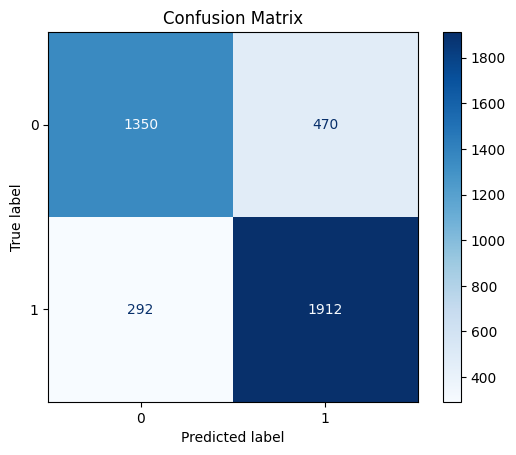

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on validation data
y_pred_proba = model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

# Optionally display it visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#print("Confusion Matrix:")
#print(confusion_matrix(y_val, y_pred))

AUC Score: 0.8927447099180311


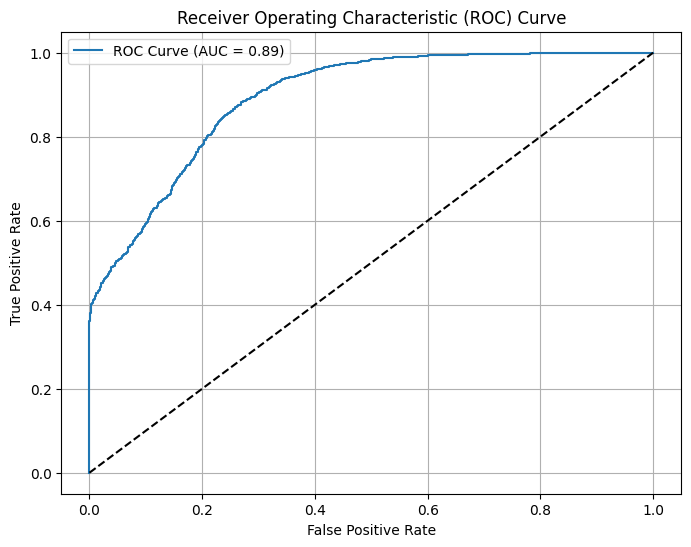

In [11]:
# Calculate AUC
auc_score = roc_auc_score(y_val, y_pred_proba)
print("AUC Score:", auc_score)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

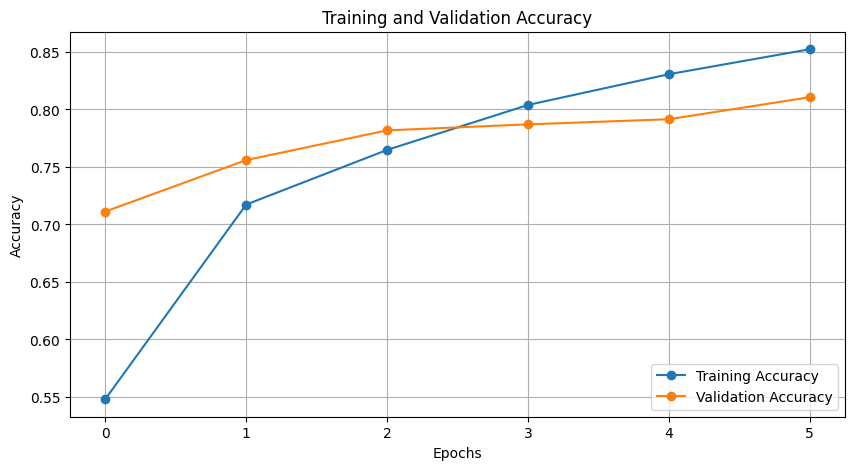

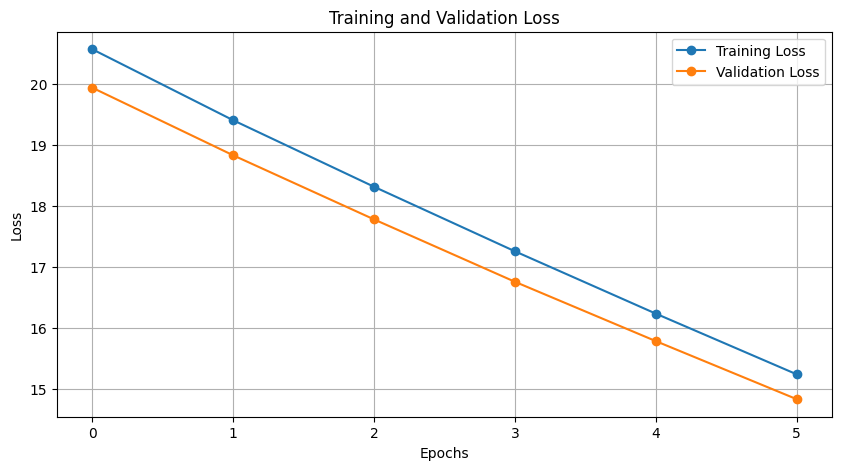

In [12]:
import matplotlib.pyplot as plt

# Assuming `history` is the output from `model.fit()`
# Example: history = model.fit(train_data, validation_data=val_data, epochs=10)

# Extract training and validation accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy', marker='o')
plt.plot(validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss', marker='o')
plt.plot(validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [15]:
model.save("resnet50_forgery_detection.h5")
print("Model saved successfully!")

Model saved successfully!


In [14]:
image_path = 'Tp_D_NNN_S_B_art00003_cha00028_01427.tif'
image = cv2.imread(image_path)
#cv2.imshow(image_path)
image = cv2.resize(image, (224, 224))  # Resize to match the input shape expected by ResNet50
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (since ResNet50 expects RGB)
image = np.expand_dims(image, axis=0)
    
prediction = model.predict(image)
print(prediction[0][0])

if prediction[0][0] > 0.5:
    print("Forged Image")
else:
    print("Authentic Image")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
0.58671665
Forged Image
